In [97]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

### Get number of films in a watchlist

In [51]:
def get_watchlist_count(username):
    page_url = f"https://letterboxd.com/{username}/watchlist/"
    response = requests.get(page_url)
    if response.status_code == 200:
        # get soup object
        soup = BeautifulSoup(response.text, 'html.parser')

        # get number of total films in watchlist
        watchlist_count_element = soup.find('span', class_='js-watchlist-count')
        if watchlist_count_element:
            watchlist_count_text = watchlist_count_element.text
            watchlist_count = int(watchlist_count_text.split()[0])
    return watchlist_count


### Get movie titles in a watchlist

In [52]:
# Function to extract movie titles from a Letterboxd watchlist URL
def get_movie_titles(username):

    movie_titles = []

    # get 1st page
    page_url = f"https://letterboxd.com/{username}/watchlist/"
    response = requests.get(page_url)
    if response.status_code == 200:
        # get soup object
        soup = BeautifulSoup(response.text, 'html.parser')

        # get movie titles on 1st page
        movies = soup.find_all('div', class_='film-poster')
        for movie in movies:
            # get movie title
            title = movie['data-film-slug']
            # append movie title to list
            movie_titles.append(title)

    # get movies on pages 2-end
    # 1st watchlist page uses the watchlist url... 
    # 2nd page and beyond uses the watchlist url + page number
    page = 2
    while True:
        page_url = f"https://letterboxd.com/{username}/watchlist/page/{page}/"
        response = requests.get(page_url)
        if response.status_code == 200:
            # get soup object
            soup = BeautifulSoup(response.text, 'html.parser')

            # get movie titles on this page
            movies = soup.find_all('div', class_='film-poster')
            if not movies:
                break  # no movies on this page
            
            # get movies on this page
            for movie in movies: 
                # get movie title
                title = movie['data-film-slug']
                # append movie title to list
                movie_titles.append(title)
            page += 1
        else:
            break  # Error or no more pages
    return movie_titles

### Get only movie titles in all selected watchlists

In [53]:
def get_common_movies_list(usernames):
    all_movies_list = []

    for user in usernames:
        count = get_watchlist_count(user)
        watchlist = get_movie_titles(user)
        # make sure correct # in watchlist
        print(f"{user} has {count} movies in their watchlist")
        assert count == len(watchlist), f"ERORR: something is wrong about number of items in watchlist - {count} != {len(watchlist)}"
        all_movies_list.append(watchlist)

    
    common_movies = set(all_movies_list[0])
    for movies_list in all_movies_list[1:]:
        common_movies = common_movies.intersection(movies_list)
    return list(common_movies)

### Get data for each movie in a shared watchlist

In [54]:
def get_movie_stats(data_film_slug):
    # Construct the movie URL using the film-id
    movie_url = f"https://letterboxd.com/film/{data_film_slug}/"

    # Send a GET request to the movie URL
    response = requests.get(movie_url)

    if response.status_code == 200:
        # Parse the HTML content of the movie page
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the relevant meta tags
        director_tag = soup.find('meta', {'name': 'twitter:data1'})
        rating_tag = soup.find('meta', {'name': 'twitter:data2'})
        og_title_tag = soup.find('meta', {'property': 'og:title'})
        duration_tag = soup.find('p', class_='text-link text-footer')
        # accounts for movies with 1 Genre or Multiple Genres
        genre_header = soup.find(lambda tag: tag.name == 'h3' and (tag.text == 'Genre' or tag.text == 'Genres'))
        
        # Extract the content from the meta tags
        director = director_tag.get('content') if director_tag else None
        rating = float(rating_tag.get('content').split(' ')[0]) if rating_tag else None
        title = og_title_tag.get('content').split('(')[0] if og_title_tag else None
        year = og_title_tag.get('content').split('(')[-1].strip(')') if og_title_tag else None
        duration = duration_tag.text.strip().split()[0]
        # get genre(s)
        if not genre_header:
            genre=None
        else:
            genre_div = genre_header.find_next('div', class_='text-sluglist')
            # Find all <a> tags within the genre_div and extract their text
            genres = [a.text for a in genre_div.find_all('a', class_='text-slug')]
            genres = ', '.join(genres)

    else:
        print(f"Error: Failed to retrieve movie stats for {data_film_slug}.")
    return director, rating, title, genres, year, duration

### Make a df with data for all shared movies

In [55]:
def get_common_movies_df(common_movies_list):
    common_movies_df = pd.DataFrame(columns=['Title', 'Rating', 'Director', 'Genre', 'Year', 'Duration (mins)'])
    # Iterate through the common_movies list
    for movie in common_movies_list:
        # Get the movie stats using the get_movie_stats function
        director, rating, title, genres, year, duration = get_movie_stats(movie)
        
        # Append the movie stats to the DataFrame
        common_movies_df = pd.concat([common_movies_df, pd.DataFrame([[title, rating, director, genres, year, duration]], columns=['Title', 'Rating', 'Director', 'Genre', 'Year', 'Duration (mins)'])])
    # Print the DataFrame
    common_movies_df.reset_index()
    common_movies_df_sorted = common_movies_df.sort_values(by='Rating', ascending=False)
    common_movies_df_sorted.reset_index(drop=True, inplace=True)
    return common_movies_df_sorted


### Get df

In [96]:
# define users
users = ['gfajardo555', 'romekk', 'shaydog'] ## CHANGE ME

common_movies_list = get_common_movies_list(users)

print()
if len(users) == 2:
    print(f"{users[0]} and {users[1]} have {len(common_movies_list)} watchlist movies in common.")
elif len(users) > 2:
    user_list_str = ', '.join(users[:-1]) + ', and ' + users[-1]
    print(f"{user_list_str} have {len(common_movies_list)} watchlist movies in common.")


common_movies_df = get_common_movies_df(common_movies_list)

save_dir = f"{'_'.join(users)}_common_watchlist.csv"
common_movies_df.to_csv(save_dir)
common_movies_df.head()


gfajardo555 has 538 movies in their watchlist
romekk has 128 movies in their watchlist
shaydog has 483 movies in their watchlist

gfajardo555, romekk, and shaydog have 14 movies in common.


,Title,Rating,Director,Genre,Year,Duration (mins)
0,Come and See,4.64,Elem Klimov,"War, Drama",1985,142
1,La Haine,4.51,Mathieu Kassovitz,Drama,1995,98
2,The Pianist,4.37,Roman Polanski,"Drama, War",2002,150
3,Dr. Strangelove or: How I Learned to Stop Worr...,4.31,Stanley Kubrick,"Comedy, War",1964,95
4,Mulholland Drive,4.24,David Lynch,"Mystery, Drama, Thriller",2001,147


# Make a scatterplot 

In [101]:
def plot_low_dur_high_rate_movies(common_movies_df, min_rating=4.2, max_duration=100, font_size=9, save_dir=None):

    # load and clean df
    common_movies_df = common_movies_df.dropna()
    common_movies_df['Duration (mins)'] = pd.to_numeric(common_movies_df['Duration (mins)'])
    common_movies_df['Rating'] = pd.to_numeric(common_movies_df['Rating'], errors='coerce')
    common_movies_df = common_movies_df.dropna(subset=['Rating'])

    # filter df by duration and rating
    filtered_df = common_movies_df[(common_movies_df['Duration (mins)'] < max_duration) & (common_movies_df['Rating'] > min_rating)]

    plt.scatter(filtered_df['Duration (mins)'], filtered_df['Rating'], color='skyblue')

    # Adding labels and title
    for i in range(len(filtered_df)):
        plt.text(filtered_df['Duration (mins)'].iloc[i], filtered_df['Rating'].iloc[i], 
                filtered_df['Title'].iloc[i], fontsize=font_size)
    plt.xlabel('Duration (mins)')
    plt.ylabel('Rating')
    plt.title('Short Duration and High Rating Films')
    plt.grid(True)
    if save_dir:
        plt.savefig(save_dir)
    plt.show()


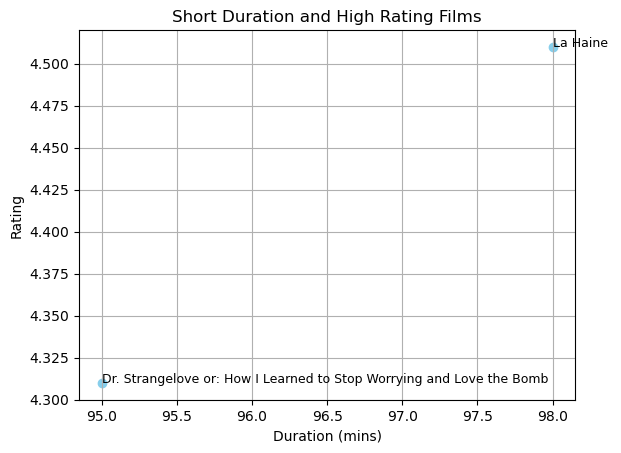

In [102]:
plot_low_dur_high_rate_movies(common_movies_df, min_rating=4.2, max_duration=100, save_dir=None)